# **FORECASTING**

**Forecasting** adalah memprediksi atau meramalkan kejadian di masa depan dengan menggunakan data pada masa sebelumnya sebagai pertimbangan
- Area yang digunakan : Saya mengambil data NO2 di sebagian besar Kabupaten Gresik dan Sekitarnya
- Tujuan Analisis : Untuk memahami pola konsentrasi gas Nitrogen (NO2) di wilayah kabupaten Gresik dan Sekitarnya dalam rentang waktu 1 bulan

## Data Understanding

### Sumber Data

- Dataset : SENTINEL_5P_L2
- Penyedia : Copernicus Data Space (Melalui API OpenEO)
- Tipe data : Citra satelit atrmosfer
- Format hasil : CSV

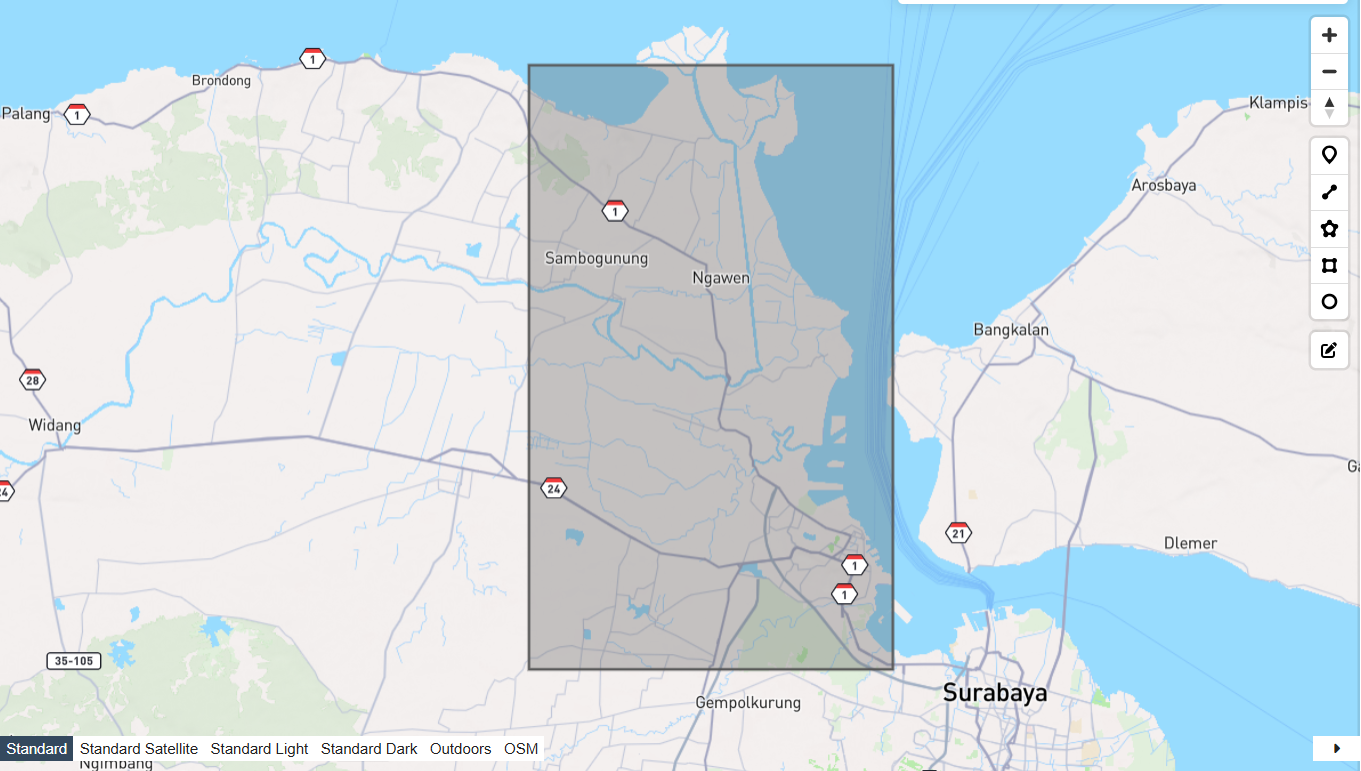

### NO2 Data Collection
Mengumpulkan data dan dijadikan format CSV.

In [1]:
!pip install xarray pandas openeo



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


Import Library Pendukung

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import openeo
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

Scraping Data

In [3]:


# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. AOI: poligon kedua dari data kamu 
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
                        [
              112.457276386427,
              -6.871540659610858
            ],
            [
              112.457276386427,
              -7.232534927888068
            ],
            [
              112.67620590724198,
              -7.232534927888068
            ],
            [
              112.67620590724198,
              -6.871540659610858
            ],
            [
              112.457276386427,
              -6.871540659610858
            ]
        ]
    ],
}

# 3. Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.457276386427,
        "south": -7.232534927888068,
        "east": 112.67620590724198,
        "north": -6.871540659610858,
    },
    temporal_extent=["2025-09-23", "2025-10-22"],
    bands=["NO2"],
)

# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV hasil
import os
for f in os.listdir("no2_results"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("no2_results", f))
        print("File ditemukan:", f)
        break

# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()


Authenticated using refresh token.
0:00:00 Job 'j-251102120414456d90a7afda2f356807': send 'start'
0:00:13 Job 'j-251102120414456d90a7afda2f356807': created (progress 0%)
0:00:19 Job 'j-251102120414456d90a7afda2f356807': created (progress 0%)
0:00:25 Job 'j-251102120414456d90a7afda2f356807': created (progress 0%)
0:00:33 Job 'j-251102120414456d90a7afda2f356807': created (progress 0%)
0:00:43 Job 'j-251102120414456d90a7afda2f356807': created (progress 0%)
0:00:56 Job 'j-251102120414456d90a7afda2f356807': running (progress N/A)
0:01:11 Job 'j-251102120414456d90a7afda2f356807': running (progress N/A)
0:01:31 Job 'j-251102120414456d90a7afda2f356807': running (progress N/A)
0:01:55 Job 'j-251102120414456d90a7afda2f356807': running (progress N/A)
0:02:25 Job 'j-251102120414456d90a7afda2f356807': finished (progress 100%)
File ditemukan: timeseries.csv


/tmp/ipykernel_2792/2108165909.py:77: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


### Baca Dataset

In [4]:
new_df = pd.read_csv('no2_results/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

,date,feature_index,NO2
0,2025-09-22,0,NaN
1,2025-09-23,0,0.000112
2,2025-09-24,0,0.000202
3,2025-09-25,0,0.000073
4,2025-09-26,0,0.000043
5,2025-09-27,0,0.000034
6,2025-09-28,0,0.000026
7,2025-09-29,0,0.000038
8,2025-09-30,0,NaN
9,2025-10-01,0,NaN


Struktur Kolom

- Setiap baris = satu hari pengamatan.
- Kolom NO2 merepresentasikan rata-rata kandungan NO₂ di atmosfer di atas area AOI pada hari tersebut.
- Nilai kecil seperti 0.000112 ≈ 1.12 × 10⁻⁴ mol/m², yang masih tergolong rendah (udara relatif bersih).


### Deteksi Missing Value

Ada 4 missing value atau missing value, Nantinya akan ditangani dengan Interpolasi

In [5]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,4,13.33


### Visualisasi NO2

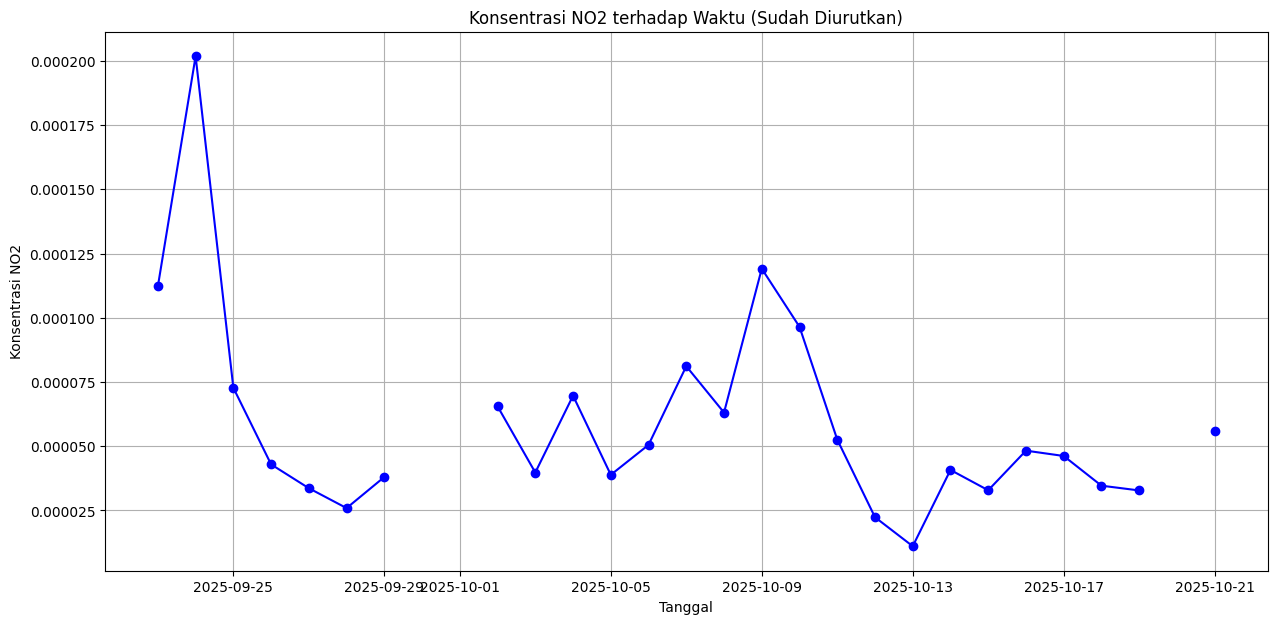

In [6]:

#     tapi bisa juga diletakkan di sini)
df['date'] = pd.to_datetime(df['date'])

# 2. Urutkan DataFrame berdasarkan kolom 'date'
df_sorted = df.sort_values(by='date')

# 3. Plot data yang sudah diurutkan (gunakan df_sorted)
plt.figure(figsize=(15, 7))
plt.plot(df_sorted['date'], df_sorted['NO2'], marker='o', linestyle='-', color='blue')
plt.title('Konsentrasi NO2 terhadap Waktu (Sudah Diurutkan)')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.grid(True)
plt.show()

## Data Preprocessing

### Tangani Missing Value dengan Interpolasi

In [7]:
new_df = pd.Series(new_df['NO2'].values, index=new_df['date'], name='NO2')
new_df = new_df.interpolate(method='linear').bfill()
new_df = pd.DataFrame(new_df).reset_index()
new_df.to_csv("no2_results/timeseries.csv")
new_df.head(5)

,date,NO2
0,2025-09-22,0.000112
1,2025-09-23,0.000112
2,2025-09-24,0.000202
3,2025-09-25,0.000073
4,2025-09-26,0.000043


### Cek Ulang Missing Value

Setelah ditangani kini sudah bersih dari missing value 

In [8]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.0
NO2,0,0.0


### Visusalisasi setelah menangani missing value

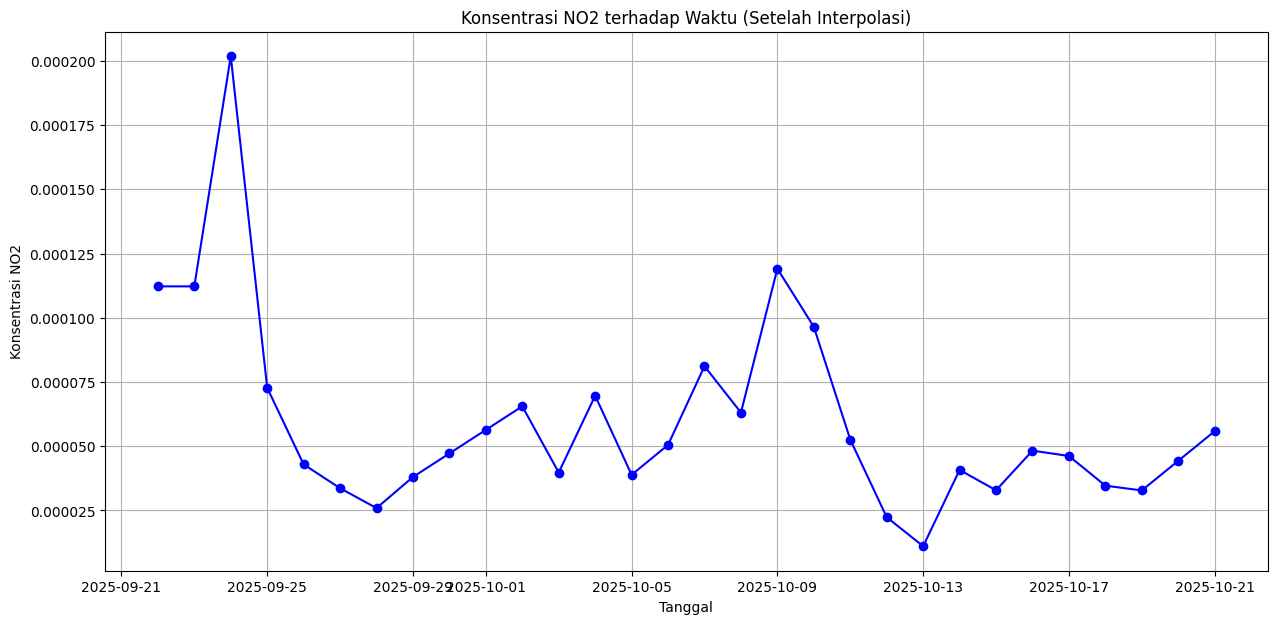

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(new_df['date'], new_df['NO2'], marker='o', linestyle='-', color='blue')
plt.title('Konsentrasi NO2 terhadap Waktu (Setelah Interpolasi)')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.grid(True)
plt.show()

## Convert Menjadi Supervised Learning

### Inisialisasi hari ke 2 - 5

In [10]:
h2 = new_df
h3 = new_df
h4 = new_df
h5 = new_df

### Data Supervised h1 & h2

In [11]:
h2 = h2.drop(columns=['date'])
hari = 2

for i in range(1, hari + 1):
    names = f"h{i}"
    h2[names] = h2['NO2'].shift(i)

h2 = h2.dropna().reset_index(drop=True)
h2

,NO2,h1,h2
0,0.000202,0.000112,0.000112
1,0.000073,0.000202,0.000112
2,0.000043,0.000073,0.000202
3,0.000034,0.000043,0.000073
4,0.000026,0.000034,0.000043
5,0.000038,0.000026,0.000034
6,0.000047,0.000038,0.000026
7,0.000056,0.000047,0.000038
8,0.000066,0.000056,0.000047
9,0.000040,0.000066,0.000056


### Data Supervised h1, h2, dan h3

In [12]:
h3 = h3.drop(columns=['date'])
hari = 3

for i in range(1, hari + 1):
    names = f"h{i}"
    h3[names] = h3['NO2'].shift(i)

h3 = h3.dropna().reset_index(drop=True)
h3

,NO2,h1,h2,h3
0,0.000073,0.000202,0.000112,0.000112
1,0.000043,0.000073,0.000202,0.000112
2,0.000034,0.000043,0.000073,0.000202
3,0.000026,0.000034,0.000043,0.000073
4,0.000038,0.000026,0.000034,0.000043
5,0.000047,0.000038,0.000026,0.000034
6,0.000056,0.000047,0.000038,0.000026
7,0.000066,0.000056,0.000047,0.000038
8,0.000040,0.000066,0.000056,0.000047
9,0.000070,0.000040,0.000066,0.000056


### Data Supervised h1, h2, h3, dan h4

In [13]:
h4 = h4.drop(columns=['date'])
hari = 4

for i in range(1, hari + 1):
    names = f"h{i}"
    h4[names] = h4['NO2'].shift(i)

h4 = h4.dropna().reset_index(drop=True)
h4

,NO2,h1,h2,h3,h4
0,0.000043,0.000073,0.000202,0.000112,0.000112
1,0.000034,0.000043,0.000073,0.000202,0.000112
2,0.000026,0.000034,0.000043,0.000073,0.000202
3,0.000038,0.000026,0.000034,0.000043,0.000073
4,0.000047,0.000038,0.000026,0.000034,0.000043
5,0.000056,0.000047,0.000038,0.000026,0.000034
6,0.000066,0.000056,0.000047,0.000038,0.000026
7,0.000040,0.000066,0.000056,0.000047,0.000038
8,0.000070,0.000040,0.000066,0.000056,0.000047
9,0.000039,0.000070,0.000040,0.000066,0.000056


### Data Supervised h1, h2, h3, h4, dan h5

In [14]:
h5 = h5.drop(columns=['date'])
hari = 5

for i in range(1, hari + 1):
    names = f"h{i}"
    h5[names] = h5['NO2'].shift(i)

h5 = h5.dropna().reset_index(drop=True)
h5

,NO2,h1,h2,h3,h4,h5
0,0.000034,0.000043,0.000073,0.000202,0.000112,0.000112
1,0.000026,0.000034,0.000043,0.000073,0.000202,0.000112
2,0.000038,0.000026,0.000034,0.000043,0.000073,0.000202
3,0.000047,0.000038,0.000026,0.000034,0.000043,0.000073
4,0.000056,0.000047,0.000038,0.000026,0.000034,0.000043
5,0.000066,0.000056,0.000047,0.000038,0.000026,0.000034
6,0.000040,0.000066,0.000056,0.000047,0.000038,0.000026
7,0.000070,0.000040,0.000066,0.000056,0.000047,0.000038
8,0.000039,0.000070,0.000040,0.000066,0.000056,0.000047
9,0.000051,0.000039,0.000070,0.000040,0.000066,0.000056



## Data Modelling



### MAPE

In [15]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Menghitung Mean Absolute Percentage Error (MAPE).
    Menghindari pembagian dengan nol.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Menghindari pembagian dengan nol (jika y_true ada yang 0)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan # Tidak ada data valid untuk dihitung
        
    # Hitung MAPE hanya pada data yang y_true-nya bukan 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return mape

In [16]:
list_scores = []

### Modelling Data h1 dan h2 menggunakan KNN Regression

In [17]:
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
h2_predict = knn.predict(X_test_scaled)
r2_h2 = r2_score(y_test, h2_predict)
mse_h2 = mean_squared_error(y_test, h2_predict)

print("MSE:", mse_h2)
print("R2:", r2_h2)

MSE: 3.0566775240666184e-09
R2: 0.14528612960538678


#### MAPE dengan 2 lag

In [18]:
# --- Modelling Data h1 dan h2 ---
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_h2 = MinMaxScaler()
X_train_scaled = scaler_h2.fit_transform(X_train)
X_test_scaled = scaler_h2.transform(X_test)

knn_h2 = KNeighborsRegressor(n_neighbors=5)
knn_h2.fit(X_train_scaled, y_train)
h2_predict = knn_h2.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h2 = mean_absolute_percentage_error(y_test, h2_predict)
print(f"MAPE h2: {mape_h2:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h2',  # <-- Label yang benar
    'MAPE': mape_h2
}
list_scores.append(scores)

MAPE h2: 33.87 %


Pakai Min-Max

### Modelling Data h1, h2, dan h3 menggunakan K-NN Regression

In [19]:
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h3_predict = knn.predict(X_test_scaled)
r2_h3 = r2_score(y_test, h3_predict)
mse_h3 = mean_squared_error(y_test, h3_predict)

print("MSE:", mse_h3)
print("R²:", r2_h3)

MSE: 1.9205278480596473e-10
R²: -0.3392590607237984


#### MAPE dengan 3 lag

In [20]:
# --- Modelling Data h1 dan h3 ---
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_h3 = MinMaxScaler()
X_train_scaled = scaler_h3.fit_transform(X_train)
X_test_scaled = scaler_h3.transform(X_test)

knn_h3 = KNeighborsRegressor(n_neighbors=5)
knn_h3.fit(X_train_scaled, y_train)
h3_predict = knn_h3.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h3 = mean_absolute_percentage_error(y_test, h3_predict)
print(f"MAPE h3: {mape_h3:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h3',  # <-- Label yang benar
    'MAPE': mape_h3
}
list_scores.append(scores)


MAPE h3: 18.52 %


### Modelling Data h1, h2, h3, dan h4 menggunakan K-NN Regression

In [21]:
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h4_predict = knn.predict(X_test_scaled)
r2_h4 = r2_score(y_test, h4_predict)
mse_h4 = mean_squared_error(y_test, h4_predict)

print("MSE:", mse_h4)
print("R²:", r2_h4)

MSE: 6.08486045030981e-10
R²: -0.5688276864581683


#### MAPE dengan 4 lag

In [22]:
# --- Modelling Data h1 dan h4 ---
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_h4 = MinMaxScaler()
X_train_scaled = scaler_h4.fit_transform(X_train)
X_test_scaled = scaler_h4.transform(X_test)

knn_h4 = KNeighborsRegressor(n_neighbors=5)
knn_h4.fit(X_train_scaled, y_train)
h4_predict = knn_h4.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h4 = mean_absolute_percentage_error(y_test, h4_predict)
print(f"MAPE h4: {mape_h4:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h4',  # <-- Label yang benar
    'MAPE': mape_h4
}
list_scores.append(scores)

MAPE h4: 54.70 %


### Modelling Data h1 h2, h3, h4, dan h5 menggunakan K-NN Regression

In [23]:
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h5_predict = knn.predict(X_test_scaled)
r2_h5 = r2_score(y_test, h5_predict)
mse_h5 = mean_squared_error(y_test, h5_predict)

print("MSE:", mse_h5)
print("R²:", r2_h5)

MSE: 5.450323344993411e-10
R²: -0.9263146495531278


#### MAPE dengan 5 lag

In [24]:
# --- Modelling Data h1 dan h5 ---
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_h5 = MinMaxScaler()
X_train_scaled = scaler_h5.fit_transform(X_train)
X_test_scaled = scaler_h5.transform(X_test)

knn_h5 = KNeighborsRegressor(n_neighbors=5)
knn_h5.fit(X_train_scaled, y_train)
h5_predict = knn_h5.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h5 = mean_absolute_percentage_error(y_test, h5_predict)
print(f"MAPE h5: {mape_h5:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h5',  # <-- Label yang benar
    'MAPE': mape_h5
}
list_scores.append(scores)

MAPE h5: 98.27 %


### Perbandingan nilai R2

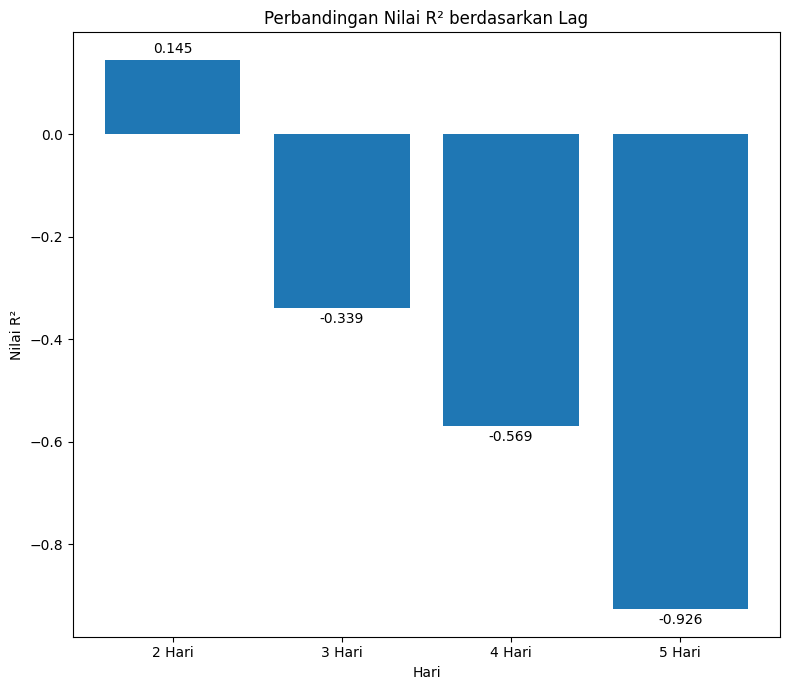

In [25]:
x = ['2 Hari', '3 Hari', '4 Hari', '5 Hari']
y = [r2_h2, r2_h3, r2_h4, r2_h5]
knn = KNeighborsRegressor(n_neighbors=2)

fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(x, y)

ax.set_title("Perbandingan Nilai R² berdasarkan Lag")
ax.set_xlabel("Hari")
ax.set_ylabel("Nilai R²")   

ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

### Perbandingan MAPE tiap lag


Data yang Digunakan untuk Chart (Urutan Eksekusi):
| Lag   |    MAPE |
|:------|--------:|
| h1-h2 | 33.8674 |
| h1-h3 | 18.5151 |
| h1-h4 | 54.7003 |
| h1-h5 | 98.2664 |


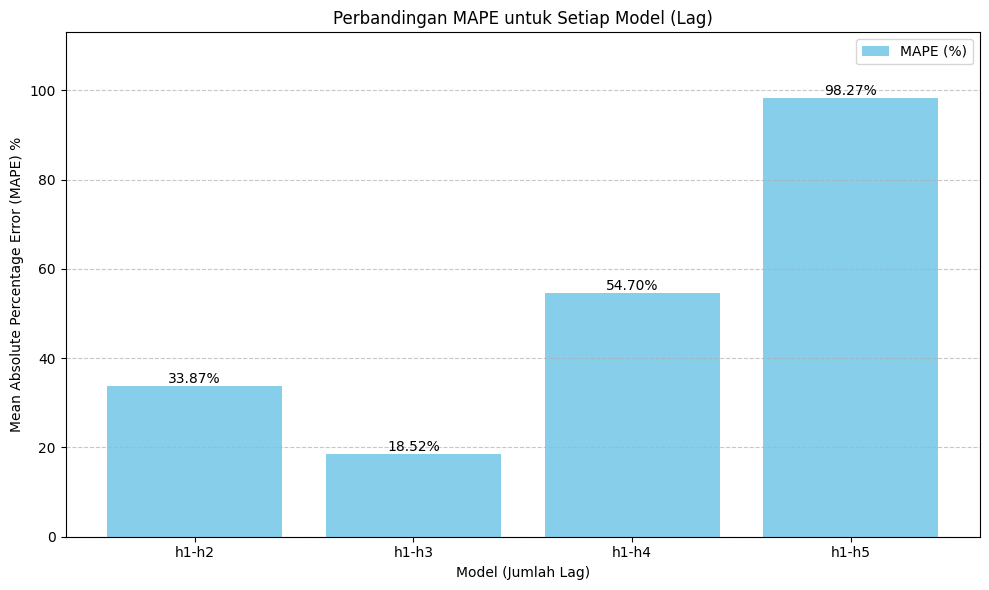

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    # Mengubah list of dictionaries menjadi DataFrame
    scores_df = pd.DataFrame(list_scores)

    # --- Membuat Bar Chart ---
    plt.figure(figsize=(10, 6))

    # Gunakan 'scores_df' (bukan scores_df_sorted) untuk plotting
    bars = plt.bar(scores_df['Lag'], scores_df['MAPE'], color='skyblue', label='MAPE (%)')

    # Menambahkan label nilai di atas setiap bar
    for bar in bars:
        yval = bar.get_height()
        # Menampilkan nilai MAPE dengan 2 angka desimal
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center') 

    plt.title('Perbandingan MAPE untuk Setiap Model (Lag)')
    plt.xlabel('Model (Jumlah Lag)')
    plt.ylabel('Mean Absolute Percentage Error (MAPE) %')
    
    # Atur batas Y (menggunakan scores_df)
    if not scores_df.empty:
        plt.ylim(0, max(scores_df['MAPE']) * 1.15) 
    else:
        plt.ylim(0, 10) # Batas default jika data kosong

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

        
    # Menampilkan tabel data (menggunakan scores_df)
    print("\nData yang Digunakan untuk Chart (Urutan Eksekusi):")
    print(scores_df.to_markdown(index=False, floatfmt=".4f"))
    
    plt.show() # <-- Menampilkan chart

except NameError:
    print("--- ERROR ---")
    print("Variabel 'list_scores' belum terdefinisi.")
    print("Pastikan Anda sudah menjalankan cell-cell modelling (h2, h3, h4, h5) sebelumnya.")
except Exception as e:
    print(f"Terjadi error: {e}")
    print("Pastikan 'list_scores' Anda berisi data yang valid.")

Dari hasil ini lag 3 hari adalah model yang terbaik

## Hasil prediksi hari berikutnya

In [27]:
# --- Prediksi Hari Berikutnya (Versi Perbaikan) ---

# 1. Ambil 3 nilai NO2 terakhir
last_3_values = new_df['NO2'].values[-3:]
print(f"Data input (3 hari terakhir)")

# 2. TENTUKAN NAMA FITUR (sesuai dengan model h1-h3)
#    (Ini adalah kolom X dari cell modelling h3 Anda)
feature_names = ['h1', 'h2', 'h3'] 

# 3. Ubah input menjadi DataFrame DENGAN NAMA FITUR
input_df = pd.DataFrame([last_3_values], columns=feature_names)

# 4. Scale data input menggunakan scaler yang sesuai (scaler_h3)
try:
    # Sekarang scaler akan melihat nama kolom dan tidak akan warning
    input_data_scaled = scaler_h3.transform(input_df)

    # 5. Buat prediksi menggunakan model terbaik Anda (knn_h3)
    predicted_no2 = knn_h3.predict(input_data_scaled)

    print("\n--- HASIL PREDIKSI ---")
    print(f"Prediksi konsentrasi NO2 untuk hari berikutnya adalah: {predicted_no2[0]:.8f}")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"Error: {e}. Pastikan variabel 'scaler_h3' dan 'knn_h3' sudah terdefinisi")
    print("dari cell modelling h1-h3 Anda.")
except Exception as e:
    print(f"\nTerjadi error lain: {e}")

Data input (3 hari terakhir)

--- HASIL PREDIKSI ---
Prediksi konsentrasi NO2 untuk hari berikutnya adalah: 0.00003765


### Cek apakah kadar NO2 hari berikutnya baik atau tidak baik

In [28]:
# Asumsi 'predicted_no2' adalah list/array berisi [0.00003765]
# Asumsi 'new_df' adalah DataFrame Anda yang sudah bersih
try:
    pred_value = predicted_no2[0]

    # 1. Hitung ambang batas statistik dari data historis Anda (new_df)
    
    # Median (50% data berada di bawah nilai ini)
    median_val = new_df['NO2'].quantile(0.50) 
    
    # Kuantil Atas (75% data berada di bawah nilai ini)
    upper_quantile_val = new_df['NO2'].quantile(0.75) 

    print(f"Nilai Prediksi \t\t: {pred_value:.8f} mol/m^2")
    print(f"Median Historis (Batas 'Baik')\t: {median_val:.8f} mol/m^2")
    print(f"Kuantil Atas (Batas 'Sedang')\t: {upper_quantile_val:.8f} mol/m^2")

    # 2. Buat kategori berdasarkan perbandingan
    if pred_value <= median_val:
        kategori = "Baik"
        penjelasan = f"Nilai ini berada di bawah atau sama dengan batas baik."
    elif pred_value <= upper_quantile_val:
        kategori = "Sedang"
        penjelasan = f"Nilai ini di atas median, tapi di bawah kuantil atas ({upper_quantile_val:.8f})."
    else:
        kategori = "Tinggi (Tidak Baik)"
        penjelasan = f"Nilai ini berada di atas 75% dari data historis Anda (lebih tinggi dari {upper_quantile_val:.8f})."

    print("\n-------------------------------------------------")
    print(f"Kategori Prediksi : **{kategori}**")
    print(f"Penjelasan: {penjelasan}")
    print("-------------------------------------------------")

except NameError:
    print("Error: Pastikan variabel 'predicted_no2' dan 'new_df' sudah ada.")
except Exception as e:
    print(f"Terjadi error: {e}")

Nilai Prediksi 		: 0.00003765 mol/m^2
Median Historis (Batas 'Baik')	: 0.00004774 mol/m^2
Kuantil Atas (Batas 'Sedang')	: 0.00006864 mol/m^2

-------------------------------------------------
Kategori Prediksi : **Baik**
Penjelasan: Nilai ini berada di bawah atau sama dengan batas baik.
-------------------------------------------------


## Deployment Menggunakan Streamlit

In [37]:
new_df.to_csv('no2_data.csv', index=False)

In [38]:
import joblib
joblib.dump(knn_h3, 'knn_model.joblib')

['knn_model.joblib']

In [39]:
joblib.dump(scaler_h3, 'scaler.joblib')

['scaler.joblib']

In [40]:
import joblib

try:
    # --- Ekspor Model h2 ---
    joblib.dump(knn_h2, 'knn_model_h2.joblib')
    joblib.dump(scaler_h2, 'scaler_h2.joblib')
    
    # --- Ekspor Model h3 ---
    joblib.dump(knn_h3, 'knn_model_h3.joblib')
    joblib.dump(scaler_h3, 'scaler_h3.joblib')
    
    # --- Ekspor Model h4 ---
    joblib.dump(knn_h4, 'knn_model_h4.joblib')
    joblib.dump(scaler_h4, 'scaler_h4.joblib')
    
    # --- Ekspor Model h5 ---
    joblib.dump(knn_h5, 'knn_model_h5.joblib')
    joblib.dump(scaler_h5, 'scaler_h5.joblib')
    
    print("BERHASIL! 8 file model/scaler telah diekspor.")
    # (Pastikan no2_data.csv juga sudah diekspor)

except NameError as e:
    print(f"--- ERROR ---")
    print(f"Variabel tidak ditemukan: {e}")
    print("Pastikan Anda sudah menjalankan semua cell modelling (h2-h5) dan")
    print("nama variabelnya adalah knn_h2, scaler_h2, knn_h3, scaler_h3, dst.")

BERHASIL! 8 file model/scaler telah diekspor.


## Hasil Deploy

Hasil deploy bisa di akses melalui tautan https://forecasting-no2.streamlit.app/ didalamnya terdapat 
- Hasil prediksi NO2 otomatis di wilayah Gresik dan sekitarnya
- Prediksi NO2 Manual (input) di wilayah Gresik dan sekitarnya